# Final Project Exploratory Analysis

The objective of this notebook is to perform exploratory analysis on a dataset of cell images, some of which are malaria infected and some of whic are healthy, in order to create a model that can predict with high accuracy which is which. The research question to be answered is: 

1. Using only a photo of a blood cell, can I predict with a level of acccuracy equivalent to or higher than microscopy in a lab (97%), whether a Malaria infection is present? 

Plan of Action:

- Prepare the data for analysis:
    - Split data into train and validation groups
    - format the data appropriately for a neural network by scaling and normalizing 
- Start by training a basic tensorflow model to classify the images
- experiment with the model parameters, optimizer, and layers to identify the best fit
- perform additional data augmentation in order to improve the accuracy of the model and reduce any overfitting

Note: for the initial model I am using https://www.tensorflow.org/tutorials/images/classification as a guide

and https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
to guide the tuning process

In [1]:
#Import libraries
import kaggle
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
#Set my data directory *** Test data will only be used in the final report to evaluate my model
train_data_dir = "C:/Users/15856/Data 602/FinalProject/Cell_Images/cell_images/train"
train_data_dir = pathlib.Path(train_data_dir)

In [3]:
#I know from my data cleaning notebook that the data images are several different sizes, and so I will set a standard input size for them
batch_size = 32
img_height = 200
img_width = 200

In [4]:
#creating my datasets, one for training and one for validation. I selected 10% of the images for my validation set

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.1, #about 2000 images seems like a good validation set to me
  subset="training",
  seed=1212020,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24958 files belonging to 2 classes.
Using 22463 files for training.


In [5]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_data_dir,
  validation_split=0.1,
  subset="validation",
  seed=1212020,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 24958 files belonging to 2 classes.
Using 2495 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['parasitized', 'uninfected']


## Feature Engineering

In [7]:
# This stage of the data preparation, using AUTOTUNE, is for optimizing performance and allows the tf.data to tune the value dynamically
#https://www.tensorflow.org/guide/data_performance
# The cache function keeps the data in memory after the first epoch which presents bottlenecking during training
#the prefectch function overlaps the data preproccessing with training the model

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Training and Selection

In [8]:
#Finally I will create my model. This is essentially based on the defaults in the tutorial I am using. I will experiment with other activation functions later on
#Furthermore, I will keep many of the inputs, such as a 3x3 Kernel size based on research on the optimal settings https://towardsdatascience.com/deciding-optimal-filter-size-for-cnns-d6f7b56f9363
num_classes = 2

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),#2d convolutional layer over spacial images
  layers.MaxPooling2D(),#max pooling layer for 2D spacial data
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [9]:
#again, based on defaults in the tutorial as well as standards for the field. Adam is the basic optimizer to use 

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [10]:
#Review model before training
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0

In [11]:
#Train the model

epochs=10 #I will start with 10 epochs and see how the accuracy looks
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 282s 402ms/step - loss: 0.6517 - accuracy: 0.5684 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 2/10
702/702 [==============================] - 272s 387ms/step - loss: 0.6932 - accuracy: 0.4969 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 3/10
702/702 [==============================] - 262s 374ms/step - loss: 0.6932 - accuracy: 0.5015 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 4/10
702/702 [==============================] - 267s 380ms/step - loss: 0.6932 - accuracy: 0.4938 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 5/10
702/702 [==============================] - 264s 376ms/step - loss: 0.6932 - accuracy: 0.4958 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 6/10
702/702 [==============================] - 267s 380ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 7/10
702/702 [==============================] - 265s 377ms/step - loss: 0.6932 - accuracy: 0.5007 - val_loss: 0.6932 -

Some observations, the model clearly started overfitting around epoc 5 when the validation accuracy started to decrease, giving a maximum accuracy of around 96%, less than our target.

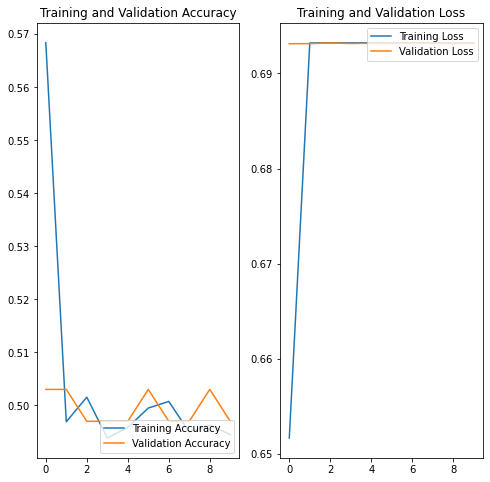

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

To help improve the overfitting, I will add some preproccessing layers to augment the data, specifically rotating, zooming in on, and flipping images.

In [13]:
#Made a change to the random flip function, so that it flips vertically and horizontally, creating greater diversity
#This made some improvement on the accuracy
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip(input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

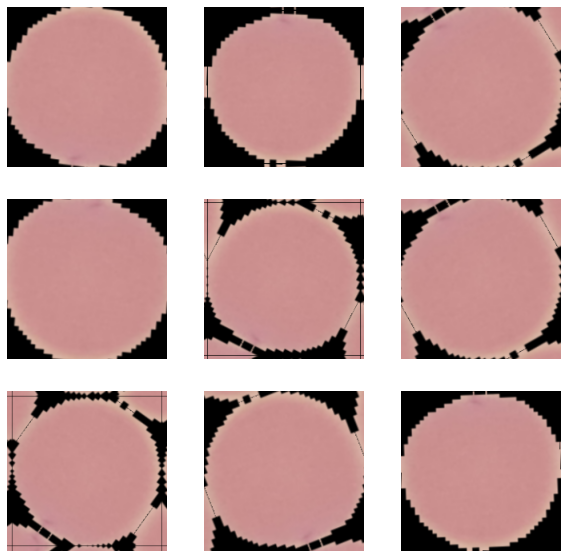

In [14]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [15]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),#This layer helps to avoid overfitting by randomly setting input units to zero at a rate of 20%
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 200, 200, 3)       0         
_________________________________________________________________
rescaling_1 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 64)       

In [18]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 313s 446ms/step - loss: 0.3702 - accuracy: 0.8355 - val_loss: 0.2112 - val_accuracy: 0.9363
Epoch 2/10
702/702 [==============================] - 308s 439ms/step - loss: 0.2028 - accuracy: 0.9330 - val_loss: 0.1621 - val_accuracy: 0.9515
Epoch 3/10
702/702 [==============================] - 309s 440ms/step - loss: 0.1706 - accuracy: 0.9461 - val_loss: 0.1825 - val_accuracy: 0.9463
Epoch 4/10
702/702 [==============================] - 307s 437ms/step - loss: 0.1551 - accuracy: 0.9510 - val_loss: 0.1178 - val_accuracy: 0.9611
Epoch 5/10
702/702 [==============================] - 305s 435ms/step - loss: 0.1481 - accuracy: 0.9533 - val_loss: 0.1259 - val_accuracy: 0.9643
Epoch 6/10
702/702 [==============================] - 304s 434ms/step - loss: 0.1382 - accuracy: 0.9569 - val_loss: 0.1155 - val_accuracy: 0.9607
Epoch 7/10
702/702 [==============================] - 310s 441ms/step - loss: 0.1345 - accuracy: 0.9570 - val_loss: 0.1150 -

Here my final accuracy has improved, but is still lower than my 97% target. I will therefore try a few different methods to improve the accuracy

In [19]:
#first, I will try with valid padding, then I will try adding a leakyrelu activation function

model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [20]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [21]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 293s 417ms/step - loss: 0.4433 - accuracy: 0.7852 - val_loss: 0.2029 - val_accuracy: 0.9399
Epoch 2/10
702/702 [==============================] - 290s 412ms/step - loss: 0.2041 - accuracy: 0.9340 - val_loss: 0.1531 - val_accuracy: 0.9583
Epoch 3/10
702/702 [==============================] - 290s 412ms/step - loss: 0.1696 - accuracy: 0.9474 - val_loss: 0.1726 - val_accuracy: 0.9483
Epoch 4/10
702/702 [==============================] - 289s 411ms/step - loss: 0.1648 - accuracy: 0.9485 - val_loss: 0.1483 - val_accuracy: 0.9559
Epoch 5/10
702/702 [==============================] - 289s 412ms/step - loss: 0.1553 - accuracy: 0.9520 - val_loss: 0.1371 - val_accuracy: 0.9599
Epoch 6/10
702/702 [==============================] - 287s 409ms/step - loss: 0.1481 - accuracy: 0.9522 - val_loss: 0.1365 - val_accuracy: 0.9575
Epoch 7/10
702/702 [==============================] - 287s 409ms/step - loss: 0.1392 - accuracy: 0.9549 - val_loss: 0.1231 -

The final accuracy was moderately improved. I will now try using the swish activation function

In [22]:
!pip install keras

In [23]:
#Next I wanted to try the swish activation, implemented below
#https://www.bignerdranch.com/blog/implementing-swish-activation-function-in-keras/
import keras
from keras.backend import sigmoid
def swish(x, beta = 1):
    return (x * sigmoid(beta * x))
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

In [24]:
# I will try adding a swish activation function, created by google, it has been shown to perform better than relu, and then I will test leaky relu to se which is optimal
#https://missinglink.ai/guides/neural-network-concepts/7-types-neural-network-activation-functions-right/

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='swish'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='swish'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='swish'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='swish'),
  layers.Dense(num_classes)
])

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 384s 547ms/step - loss: 0.5848 - accuracy: 0.6914 - val_loss: 0.3483 - val_accuracy: 0.8621
Epoch 2/10
702/702 [==============================] - 383s 545ms/step - loss: 0.2692 - accuracy: 0.8965 - val_loss: 0.2611 - val_accuracy: 0.9046
Epoch 3/10
702/702 [==============================] - 382s 544ms/step - loss: 0.2258 - accuracy: 0.9177 - val_loss: 0.1727 - val_accuracy: 0.9379
Epoch 4/10
702/702 [==============================] - 384s 547ms/step - loss: 0.2014 - accuracy: 0.9300 - val_loss: 0.1733 - val_accuracy: 0.9451
Epoch 5/10
702/702 [==============================] - 382s 545ms/step - loss: 0.1865 - accuracy: 0.9372 - val_loss: 0.1613 - val_accuracy: 0.9483
Epoch 6/10
702/702 [==============================] - 382s 545ms/step - loss: 0.1727 - accuracy: 0.9439 - val_loss: 0.1475 - val_accuracy: 0.9503
Epoch 7/10
702/702 [==============================] - 384s 547ms/step - loss: 0.1697 - accuracy: 0.9430 - val_loss: 0.1348 -

This did not really change performance. I will next attempt using the leaky relu layer in the model

In [27]:
#https://www.tensorflow.org/api_docs/python/tf/keras/layers/LeakyReLU
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid'),
  layers.LeakyReLU(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid'),
  layers.LeakyReLU(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid'),
  layers.LeakyReLU(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 309s 440ms/step - loss: 0.3934 - accuracy: 0.8255 - val_loss: 0.1860 - val_accuracy: 0.9415
Epoch 2/10
702/702 [==============================] - 308s 439ms/step - loss: 0.2028 - accuracy: 0.9366 - val_loss: 0.1675 - val_accuracy: 0.9499
Epoch 3/10
702/702 [==============================] - 307s 437ms/step - loss: 0.1771 - accuracy: 0.9452 - val_loss: 0.1559 - val_accuracy: 0.9539
Epoch 4/10
702/702 [==============================] - 309s 440ms/step - loss: 0.1646 - accuracy: 0.9480 - val_loss: 0.1295 - val_accuracy: 0.9611
Epoch 5/10
702/702 [==============================] - 307s 437ms/step - loss: 0.1631 - accuracy: 0.9486 - val_loss: 0.1347 - val_accuracy: 0.9543
Epoch 6/10
702/702 [==============================] - 308s 438ms/step - loss: 0.1552 - accuracy: 0.9510 - val_loss: 0.1248 - val_accuracy: 0.9631
Epoch 7/10
702/702 [==============================] - 308s 438ms/step - loss: 0.1519 - accuracy: 0.9520 - val_loss: 0.1254 -

This actually decreased accuracy, I will therefore return to using the relu activation function.

for my next step, I want to see if adding a layer improves output.

In [30]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 307s 437ms/step - loss: 0.5224 - accuracy: 0.7009 - val_loss: 0.1568 - val_accuracy: 0.9527
Epoch 2/10
702/702 [==============================] - 304s 433ms/step - loss: 0.1712 - accuracy: 0.9466 - val_loss: 0.1255 - val_accuracy: 0.9607
Epoch 3/10
702/702 [==============================] - 305s 435ms/step - loss: 0.1545 - accuracy: 0.9512 - val_loss: 0.1371 - val_accuracy: 0.9607
Epoch 4/10
702/702 [==============================] - 313s 446ms/step - loss: 0.1431 - accuracy: 0.9531 - val_loss: 0.1245 - val_accuracy: 0.9627
Epoch 5/10
702/702 [==============================] - 304s 433ms/step - loss: 0.1407 - accuracy: 0.9539 - val_loss: 0.1152 - val_accuracy: 0.9659
Epoch 6/10
702/702 [==============================] - 307s 437ms/step - loss: 0.1412 - accuracy: 0.9538 - val_loss: 0.1183 - val_accuracy: 0.9639
Epoch 7/10
702/702 [==============================] - 306s 436ms/step - loss: 0.1340 - accuracy: 0.9561 - val_loss: 0.1218 -

This did lead to better performance. I will therefore keep the extra layer in my final model. 

My next step will be to test other optimizers. Based on the recommendations out there: https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e ; https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
it seems like Adam is the best of the adaptive optimizers, while SGD (stochastic gradient decent) despite generally being less effective, is still able, in some cases to produce strong results. I will also try Nadam, which incorporates Nesterov Momentum into the adam algorithm (http://cs229.stanford.edu/proj2015/054_report.pdf) and Adamax which is similar to Adam and is therefore worth comparing.

In addition to the optimizers, I used tensorboard to evaluate different dropout rates and the final number of units in the dense layer. 

Note: I used Tensorboard in Google Colab to compare these models directly, but you can also see them written out below

In [33]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [34]:
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
model.compile(optimizer='Nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [35]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 315s 449ms/step - loss: 0.6925 - accuracy: 0.5704 - val_loss: 0.6273 - val_accuracy: 0.6637
Epoch 2/10
702/702 [==============================] - 314s 448ms/step - loss: 0.2033 - accuracy: 0.9299 - val_loss: 0.1362 - val_accuracy: 0.9599
Epoch 3/10
702/702 [==============================] - 312s 445ms/step - loss: 0.1559 - accuracy: 0.9506 - val_loss: 0.1452 - val_accuracy: 0.9567
Epoch 4/10
702/702 [==============================] - 313s 446ms/step - loss: 0.1436 - accuracy: 0.9530 - val_loss: 0.1173 - val_accuracy: 0.9635
Epoch 5/10
702/702 [==============================] - 311s 442ms/step - loss: 0.1396 - accuracy: 0.9556 - val_loss: 0.1199 - val_accuracy: 0.9599
Epoch 6/10
702/702 [==============================] - 312s 444ms/step - loss: 0.1360 - accuracy: 0.9566 - val_loss: 0.1105 - val_accuracy: 0.9635
Epoch 7/10
702/702 [==============================] - 314s 447ms/step - loss: 0.1317 - accuracy: 0.9572 - val_loss: 0.1231 -

In [36]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [37]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 305s 435ms/step - loss: 0.6644 - accuracy: 0.5953 - val_loss: 0.5987 - val_accuracy: 0.6790
Epoch 2/10
702/702 [==============================] - 306s 435ms/step - loss: 0.4458 - accuracy: 0.8029 - val_loss: 0.2208 - val_accuracy: 0.9138
Epoch 3/10
702/702 [==============================] - 307s 438ms/step - loss: 0.2287 - accuracy: 0.9195 - val_loss: 0.1860 - val_accuracy: 0.9371
Epoch 4/10
702/702 [==============================] - 306s 435ms/step - loss: 0.2085 - accuracy: 0.9298 - val_loss: 0.1684 - val_accuracy: 0.9487
Epoch 5/10
702/702 [==============================] - 305s 434ms/step - loss: 0.1951 - accuracy: 0.9359 - val_loss: 0.1672 - val_accuracy: 0.9435
Epoch 6/10
702/702 [==============================] - 305s 435ms/step - loss: 0.1852 - accuracy: 0.9395 - val_loss: 0.1537 - val_accuracy: 0.9559
Epoch 7/10
702/702 [==============================] - 303s 432ms/step - loss: 0.1825 - accuracy: 0.9416 - val_loss: 0.1718 -

In [39]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [40]:
model.compile(optimizer='Adamax',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 311s 443ms/step - loss: 0.4226 - accuracy: 0.7852 - val_loss: 0.1727 - val_accuracy: 0.9331
Epoch 2/10
702/702 [==============================] - 308s 438ms/step - loss: 0.1932 - accuracy: 0.9310 - val_loss: 0.1567 - val_accuracy: 0.9495
Epoch 3/10
702/702 [==============================] - 308s 439ms/step - loss: 0.1795 - accuracy: 0.9406 - val_loss: 0.1461 - val_accuracy: 0.9555
Epoch 4/10
702/702 [==============================] - 308s 439ms/step - loss: 0.1692 - accuracy: 0.9456 - val_loss: 0.1399 - val_accuracy: 0.9607
Epoch 5/10
702/702 [==============================] - 309s 440ms/step - loss: 0.1566 - accuracy: 0.9509 - val_loss: 0.1321 - val_accuracy: 0.9635
Epoch 6/10
702/702 [==============================] - 310s 441ms/step - loss: 0.1462 - accuracy: 0.9533 - val_loss: 0.1448 - val_accuracy: 0.9603
Epoch 7/10
702/702 [==============================] - 308s 439ms/step - loss: 0.1448 - accuracy: 0.9518 - val_loss: 0.1120 -

Next I will test across different units (between 128 and 256) for the dense layer. I will then test the outputs with a dropout rate of .1

In [42]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [43]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [44]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 316s 450ms/step - loss: 0.2727 - accuracy: 0.8904 - val_loss: 0.1518 - val_accuracy: 0.9527
Epoch 2/10
702/702 [==============================] - 312s 444ms/step - loss: 0.1587 - accuracy: 0.9499 - val_loss: 0.1143 - val_accuracy: 0.9635
Epoch 3/10
702/702 [==============================] - 309s 440ms/step - loss: 0.1534 - accuracy: 0.9514 - val_loss: 0.1117 - val_accuracy: 0.9643
Epoch 4/10
702/702 [==============================] - 310s 442ms/step - loss: 0.1427 - accuracy: 0.9547 - val_loss: 0.1117 - val_accuracy: 0.9639
Epoch 5/10
702/702 [==============================] - 310s 442ms/step - loss: 0.1408 - accuracy: 0.9545 - val_loss: 0.1180 - val_accuracy: 0.9635
Epoch 6/10
702/702 [==============================] - 312s 445ms/step - loss: 0.1372 - accuracy: 0.9553 - val_loss: 0.1192 - val_accuracy: 0.9615
Epoch 7/10
702/702 [==============================] - 320s 456ms/step - loss: 0.1306 - accuracy: 0.9566 - val_loss: 0.1078 -

In [45]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [46]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [47]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 317s 451ms/step - loss: 0.6829 - accuracy: 0.5524 - val_loss: 0.6558 - val_accuracy: 0.6068
Epoch 2/10
702/702 [==============================] - 320s 456ms/step - loss: 0.6182 - accuracy: 0.6609 - val_loss: 0.4871 - val_accuracy: 0.7960
Epoch 3/10
702/702 [==============================] - 318s 452ms/step - loss: 0.3351 - accuracy: 0.8685 - val_loss: 0.1846 - val_accuracy: 0.9335
Epoch 4/10
702/702 [==============================] - 332s 474ms/step - loss: 0.2287 - accuracy: 0.9224 - val_loss: 0.1762 - val_accuracy: 0.9407
Epoch 5/10
702/702 [==============================] - 355s 505ms/step - loss: 0.2070 - accuracy: 0.9278 - val_loss: 0.1687 - val_accuracy: 0.9507
Epoch 6/10
702/702 [==============================] - 310s 442ms/step - loss: 0.1926 - accuracy: 0.9365 - val_loss: 0.1858 - val_accuracy: 0.9451
Epoch 7/10
702/702 [==============================] - 338s 481ms/step - loss: 0.1829 - accuracy: 0.9417 - val_loss: 0.1641 -

In [48]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [49]:
model.compile(optimizer='Nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 356s 507ms/step - loss: 0.6884 - accuracy: 0.5525 - val_loss: 0.6669 - val_accuracy: 0.5896
Epoch 2/10
702/702 [==============================] - 507s 722ms/step - loss: 0.3461 - accuracy: 0.8352 - val_loss: 0.1411 - val_accuracy: 0.9619
Epoch 3/10
702/702 [==============================] - 461s 657ms/step - loss: 0.1605 - accuracy: 0.9487 - val_loss: 0.1311 - val_accuracy: 0.9599
Epoch 4/10
702/702 [==============================] - 571s 814ms/step - loss: 0.1477 - accuracy: 0.9521 - val_loss: 0.1214 - val_accuracy: 0.9639
Epoch 5/10
702/702 [==============================] - 590s 840ms/step - loss: 0.1410 - accuracy: 0.9532 - val_loss: 0.1243 - val_accuracy: 0.9647
Epoch 6/10
702/702 [==============================] - 643s 917ms/step - loss: 0.1354 - accuracy: 0.9551 - val_loss: 0.1332 - val_accuracy: 0.9615
Epoch 7/10
702/702 [==============================] - 676s 963ms/step - loss: 0.1326 - accuracy: 0.9562 - val_loss: 0.1175 -

In [51]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.2),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

In [52]:
model.compile(optimizer='Adamax',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [53]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 1007s 1s/step - loss: 0.4736 - accuracy: 0.7555 - val_loss: 0.1823 - val_accuracy: 0.9439
Epoch 2/10
702/702 [==============================] - 1208s 2s/step - loss: 0.2021 - accuracy: 0.9285 - val_loss: 0.1571 - val_accuracy: 0.9507
Epoch 3/10
702/702 [==============================] - 1551s 2s/step - loss: 0.1762 - accuracy: 0.9401 - val_loss: 0.1441 - val_accuracy: 0.9523
Epoch 4/10
702/702 [==============================] - 1285s 2s/step - loss: 0.1578 - accuracy: 0.9476 - val_loss: 0.1219 - val_accuracy: 0.9639
Epoch 5/10
702/702 [==============================] - 1169s 2s/step - loss: 0.1481 - accuracy: 0.9514 - val_loss: 0.1219 - val_accuracy: 0.9595
Epoch 6/10
702/702 [==============================] - 1296s 2s/step - loss: 0.1399 - accuracy: 0.9537 - val_loss: 0.1120 - val_accuracy: 0.9635
Epoch 7/10
702/702 [==============================] - 1248s 2s/step - loss: 0.1375 - accuracy: 0.9557 - val_loss: 0.1081 - val_accuracy:

Result

Finally I will test with a dropout rate of 10%

In [54]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [55]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
702/702 [==============================] - 1265s 2s/step - loss: 0.3004 - accuracy: 0.8734 - val_loss: 0.1502 - val_accuracy: 0.9575
Epoch 2/10
702/702 [==============================] - 1267s 2s/step - loss: 0.1590 - accuracy: 0.9501 - val_loss: 0.1439 - val_accuracy: 0.9623
Epoch 3/10
702/702 [==============================] - 1251s 2s/step - loss: 0.1459 - accuracy: 0.9534 - val_loss: 0.1158 - val_accuracy: 0.9627
Epoch 4/10
309/702 [============>.................] - ETA: 10:05 - loss: 0.1374 - accuracy: 0.9566

In [ ]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='Nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(.1),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='Adamax',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Okay! So my best results seem to have come from the model with one additional layer (128 filters), valid padding, relu activation function, and the nadam activation function. Below is my final training model and the result of that model on test data!

In [ ]:
model = Sequential([
  data_augmentation,#my additional data augmentation layer
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='valid', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='Nadam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#preparing my test data for the model

test_data_dir = "C:/Users/15856/Data 602/FinalProject/Cell_Images/cell_images/test"
test_data_dir = pathlib.Path(test_data_dir)

In [ ]:
batch_size = 32
img_height = 200
img_width = 200

In [ ]:
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_data_dir,
  seed=1212020,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [ ]:
model.evaluate(test_ds)